## PSTAT 134
## J Steven Raquel
## Fri 9am Section

## Assignment 2

Our objective of this assignment is to create an interactive dashboard in this Jupyter notebook, using NBA data.

### Problem 1

First we need to download the data. We can do this by using the `get_nba_data()` function that was defined in Lecture 5. We can redefine here and then utilize it. 

In [1]:
import numpy as np
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt

%matplotlib nbagg

In [2]:
# Problem 1
# from Lecture 5, Data Frame and Visualization
import pandas as pd

def get_nba_data(endpt, params, return_url=False):

    ## endpt: https://github.com/seemethere/nba_py/wiki/stats.nba.com-Endpoint-Documentation
    ## params: dictionary of parameters: i.e., {'LeagueID':'00'}
    
    from pandas import DataFrame
    from urllib.parse import urlencode
    import json
    
    useragent = "\"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2) AppleWebKit/601.3.9 (KHTML, like Gecko) Version/9.0.2 Safari/601.3.9\""
    dataurl = "\"" + "http://stats.nba.com/stats/" + endpt + "?" + urlencode(params) + "\""
    
    # for debugging: just return the url
    if return_url:
        return(dataurl)
    
    jsonstr = !wget -q -O - --user-agent={useragent} {dataurl}
    
    data = json.loads(jsonstr[0])
    
    h = data['resultSets'][0]['headers']
    d = data['resultSets'][0]['rowSet']
    
    return(DataFrame(d, columns=h))

This function allows us to directly download the NBA data, with the specific parameters that we set. The function creates a DataFrame that we can then look at, like so.

### Cleaning the data

Our first step is to import the teams and the players from the NBA into DataFrames that we can use, with the `get_nba_data()` function. The following code, taken from Lecture 5, subsets and cleans the data, and shows how to group by team abbreviation, and by code. 

In [228]:
## get all teams
params = {'LeagueID':'00'}
teams = get_nba_data('commonTeamYears', params)
teams.head()

,LEAGUE_ID,TEAM_ID,MIN_YEAR,MAX_YEAR,ABBREVIATION
0,00,1610612737,1949,2017,ATL
1,00,1610612738,1946,2017,BOS
2,00,1610612739,1970,2017,CLE
3,00,1610612740,2002,2017,NOP
4,00,1610612741,1966,2017,CHI


In [4]:
## get all players
params = {'LeagueID':'00', 'Season': '2016-17', 'IsOnlyCurrentSeason': '0'}
players = get_nba_data('commonallplayers', params)
players.head()

,PERSON_ID,DISPLAY_LAST_COMMA_FIRST,DISPLAY_FIRST_LAST,ROSTERSTATUS,FROM_YEAR,TO_YEAR,PLAYERCODE,TEAM_ID,TEAM_CITY,TEAM_NAME,TEAM_ABBREVIATION,TEAM_CODE,GAMES_PLAYED_FLAG
0,76001,"Abdelnaby, Alaa",Alaa Abdelnaby,0,1990,1994,HISTADD_alaa_abdelnaby,0,,,,,Y
1,76002,"Abdul-Aziz, Zaid",Zaid Abdul-Aziz,0,1968,1977,HISTADD_zaid_abdul-aziz,0,,,,,Y
2,76003,"Abdul-Jabbar, Kareem",Kareem Abdul-Jabbar,0,1969,1988,HISTADD_kareem_abdul-jabbar,0,,,,,Y
3,51,"Abdul-Rauf, Mahmoud",Mahmoud Abdul-Rauf,0,1990,2000,mahmoud_abdul-rauf,0,,,,,Y
4,1505,"Abdul-Wahad, Tariq",Tariq Abdul-Wahad,0,1997,2003,tariq_abdul-wahad,0,,,,,Y


In [5]:
# changing types of the columns
teams.ABBREVIATION = teams.ABBREVIATION.astype('category')
teams.TEAM_ID      = teams.TEAM_ID.astype('category')
teams.MIN_YEAR     = teams.MIN_YEAR.astype('int')
teams.MAX_YEAR     = teams.MAX_YEAR.astype('int')

In [6]:
# subset just current teams
teams = teams[teams['MAX_YEAR'] == 2017] # selecting only teams active as late as 2017
teams['TEAM_AGE'] = teams.MAX_YEAR - teams.MIN_YEAR # new columns for age of the team
teams_clean = teams.copy() ## make a copy for later 
teams_clean.head()

,LEAGUE_ID,TEAM_ID,MIN_YEAR,MAX_YEAR,ABBREVIATION,TEAM_AGE
0,00,1610612737,1949,2017,ATL,68
1,00,1610612738,1946,2017,BOS,71
2,00,1610612739,1970,2017,CLE,47
3,00,1610612740,2002,2017,NOP,15
4,00,1610612741,1966,2017,CHI,51


In [7]:
# adding 'TEAM_ABBREVIATION'
team_names = players[['TEAM_ABBREVIATION', 'TEAM_CODE']].drop_duplicates()#.set_index('TEAM_ABBREVIATION')
teams = pd.merge(teams_clean, team_names, left_on='ABBREVIATION', right_on='TEAM_ABBREVIATION')
teams.TEAM_CODE = teams.TEAM_CODE.str.capitalize() # returns values so needs to be reassigned
teams.sort_values('ABBREVIATION', inplace=True)    # modifies object
teams.head()

,LEAGUE_ID,TEAM_ID,MIN_YEAR,MAX_YEAR,ABBREVIATION,TEAM_AGE,TEAM_ABBREVIATION,TEAM_CODE
0,00,1610612737,1949,2017,ATL,68,ATL,Hawks
14,00,1610612751,1976,2017,BKN,41,BKN,Nets
1,00,1610612738,1946,2017,BOS,71,BOS,Celtics
29,00,1610612766,1988,2017,CHA,29,CHA,Hornets
4,00,1610612741,1966,2017,CHI,51,CHI,Bulls


In [8]:
# subset just the players in current teams
players = players[players.TEAM_ID.isin(teams.TEAM_ID)]
players.head()

,PERSON_ID,DISPLAY_LAST_COMMA_FIRST,DISPLAY_FIRST_LAST,ROSTERSTATUS,FROM_YEAR,TO_YEAR,PLAYERCODE,TEAM_ID,TEAM_CITY,TEAM_NAME,TEAM_ABBREVIATION,TEAM_CODE,GAMES_PLAYED_FLAG
9,203518,"Abrines, Alex",Alex Abrines,1,2016,2017,alex_abrines,1610612760,Oklahoma City,Thunder,OKC,thunder,Y
14,203112,"Acy, Quincy",Quincy Acy,1,2012,2017,quincy_acy,1610612751,Brooklyn,Nets,BKN,nets,Y
20,203500,"Adams, Steven",Steven Adams,1,2013,2017,steven_adams,1610612760,Oklahoma City,Thunder,OKC,thunder,Y
25,201167,"Afflalo, Arron",Arron Afflalo,1,2007,2017,arron_afflalo,1610612758,Sacramento,Kings,SAC,kings,Y
30,201582,"Ajinca, Alexis",Alexis Ajinca,1,2008,2017,alexis_ajinca,1610612740,New Orleans,Pelicans,NOP,pelicans,Y


In [9]:
# create a dictionary of teams with their abbreviation and team ID
team_dd_text = teams.TEAM_ABBREVIATION+', '+teams.TEAM_CODE
team_dd = dict(zip(team_dd_text, teams.TEAM_ID))
team_dd

{'ATL, Hawks': 1610612737,
 'BKN, Nets': 1610612751,
 'BOS, Celtics': 1610612738,
 'CHA, Hornets': 1610612766,
 'CHI, Bulls': 1610612741,
 'CLE, Cavaliers': 1610612739,
 'DAL, Mavericks': 1610612742,
 'DEN, Nuggets': 1610612743,
 'DET, Pistons': 1610612765,
 'GSW, Warriors': 1610612744,
 'HOU, Rockets': 1610612745,
 'IND, Pacers': 1610612754,
 'LAC, Clippers': 1610612746,
 'LAL, Lakers': 1610612747,
 'MEM, Grizzlies': 1610612763,
 'MIA, Heat': 1610612748,
 'MIL, Bucks': 1610612749,
 'MIN, Timberwolves': 1610612750,
 'NOP, Pelicans': 1610612740,
 'NYK, Knicks': 1610612752,
 'OKC, Thunder': 1610612760,
 'ORL, Magic': 1610612753,
 'PHI, Sixers': 1610612755,
 'PHX, Suns': 1610612756,
 'POR, Blazers': 1610612757,
 'SAC, Kings': 1610612758,
 'SAS, Spurs': 1610612759,
 'TOR, Raptors': 1610612761,
 'UTA, Jazz': 1610612762,
 'WAS, Wizards': 1610612764}

In [10]:
plyr_by_team_dd = dict()
for t, p in players.groupby('TEAM_ID'):
    plyr_by_team_dd[t] = dict(zip(p.DISPLAY_LAST_COMMA_FIRST, p.PERSON_ID))

plyr_by_team_dd

{1610612737: {'Bazemore, Kent': 203145,
  "Bembry, DeAndre'": 1627761,
  'Calderon, Jose': 101181,
  'Delaney, Malcolm': 1627098,
  'Dunleavy, Mike': 2399,
  'Hardaway Jr., Tim': 203501,
  'Howard, Dwight': 2730,
  'Humphries, Kris': 2743,
  'Ilyasova, Ersan': 101141,
  'Kelly, Ryan': 203527,
  'Millsap, Paul': 200794,
  'Muscala, Mike': 203488,
  'Prince, Taurean': 1627752,
  'Schroder, Dennis': 203471,
  'Sefolosha, Thabo': 200757},
 1610612738: {'Bradley, Avery': 202340,
  'Brown, Jaylen': 1627759,
  'Crowder, Jae': 203109,
  'Green, Gerald': 101123,
  'Horford, Al': 201143,
  'Jackson, Demetrius': 1627743,
  'Jerebko, Jonas': 201973,
  'Johnson, Amir': 101161,
  'Mickey, Jordan': 1626175,
  'Olynyk, Kelly': 203482,
  'Rozier, Terry': 1626179,
  'Smart, Marcus': 203935,
  'Thomas, Isaiah': 202738,
  'Young, James': 203923,
  'Zeller, Tyler': 203092},
 1610612739: {'Felder, Kay': 1627770,
  'Frye, Channing': 101112,
  'Irving, Kyrie': 202681,
  'James, LeBron': 2544,
  'Jefferson, Ri

In [11]:
plyr_by_team_dd = dict()
for t, p in players.groupby('TEAM_ID'):
    plyr_by_team_dd[t] = dict(zip(p.DISPLAY_LAST_COMMA_FIRST, p.PERSON_ID))

In [12]:
plyr_dd_text = players.DISPLAY_LAST_COMMA_FIRST
plyr_dd_id = players.PERSON_ID
plyr_dd = dict(zip(plyr_dd_text, plyr_dd_id))
plyr_dd

{'Abrines, Alex': 203518,
 'Acy, Quincy': 203112,
 'Adams, Steven': 203500,
 'Afflalo, Arron': 201167,
 'Ajinca, Alexis': 201582,
 'Aldrich, Cole': 202332,
 'Aldridge, LaMarcus': 200746,
 'Allen, Lavoy': 202730,
 'Allen, Tony': 2754,
 'Aminu, Al-Farouq': 202329,
 'Anderson, Alan': 101187,
 'Anderson, Justin': 1626147,
 'Anderson, Kyle': 203937,
 'Anderson, Ryan': 201583,
 'Antetokounmpo, Giannis': 203507,
 'Anthony, Carmelo': 2546,
 'Anthony, Joel': 201202,
 'Ariza, Trevor': 2772,
 'Arthur, Darrell': 201589,
 'Asik, Omer': 201600,
 'Augustin, D.J.': 201571,
 'Babbitt, Luke': 202337,
 'Baker, Ron': 1627758,
 'Baldwin IV, Wade': 1627735,
 'Barbosa, Leandro': 2571,
 'Barea, J.J.': 200826,
 'Barnes, Harrison': 203084,
 'Barnes, Matt': 2440,
 'Barton, Will': 203115,
 'Bass, Brandon': 101138,
 'Batum, Nicolas': 201587,
 'Bayless, Jerryd': 201573,
 'Baynes, Aron': 203382,
 'Bazemore, Kent': 203145,
 'Beal, Bradley': 203078,
 'Beasley, Malik': 1627736,
 'Beasley, Michael': 201563,
 'Belinelli,

In [16]:
from ipywidgets import interact, FloatSlider, Dropdown, Button

# selected = 'ATL, Hawks'
selected = 'LAC, Clippers'

team_menu = Dropdown(options=team_dd, label=selected)
plyr_menu = Dropdown(options=plyr_by_team_dd[team_dd[selected]])
fetch_button = Button(description='Get Data!', icon='check')

In [168]:
# an observer that watches for change events to the drop down menus
def test_team(change):
    
    print(change['new'])
    print("************")
    print(change)
    
team_menu.observe(test_team, names='label')
team_menu.observe(test_team, names=['label','value'])

In [271]:
# selected = 'ATL, Hawks'
selected = 'LAC, Clippers'

team_menu = Dropdown(options=team_dd, label=selected)
plyr_menu = Dropdown(options=plyr_by_team_dd[team_dd[selected]])
fetch_button = Button(description='Get Data!', icon='check')

display(team_menu, fetch_button)

## update players list
def update_team(change):
    plyr_menu.index = None
    plyr_menu.options = plyr_by_team_dd[change['new']]
    plyr_menu.value = list(plyr_by_team_dd[change['new']].values())[0]

team_menu.observe(update_team, names='value')

## get data action
def get_data(change):
    params = {'TeamID': team_menu.value,
         'Season':'2016-17',
         'SeasonType':'Regular Season',
         'LeagueID':'00'}
    
    team_data = get_nba_data('teaminfocommon', params)
    df = pd.DataFrame(data = team_data)
    print(df.PCT[0])
    
fetch_button.on_click(get_data)

Dropdown(index=12, options={'ATL, Hawks': 1610612737, 'BKN, Nets': 1610612751, 'BOS, Celtics': 1610612738, 'CHA, Hornets': 1610612766, 'CHI, Bulls': 1610612741, 'CLE, Cavaliers': 1610612739, 'DAL, Mavericks': 1610612742, 'DEN, Nuggets': 1610612743, 'DET, Pistons': 1610612765, 'GSW, Warriors': 1610612744, 'HOU, Rockets': 1610612745, 'IND, Pacers': 1610612754, 'LAC, Clippers': 1610612746, 'LAL, Lakers': 1610612747, 'MEM, Grizzlies': 1610612763, 'MIA, Heat': 1610612748, 'MIL, Bucks': 1610612749, 'MIN, Timberwolves': 1610612750, 'NOP, Pelicans': 1610612740, 'NYK, Knicks': 1610612752, 'OKC, Thunder': 1610612760, 'ORL, Magic': 1610612753, 'PHI, Sixers': 1610612755, 'PHX, Suns': 1610612756, 'POR, Blazers': 1610612757, 'SAC, Kings': 1610612758, 'SAS, Spurs': 1610612759, 'TOR, Raptors': 1610612761, 'UTA, Jazz': 1610612762, 'WAS, Wizards': 1610612764}, value=1610612746)

Button(description='Get Data!', icon='check', style=ButtonStyle())

0.622
0.646
0.817


NameError: name 'team_data' is not defined

### Problem 2
#### Creating widgets

This is a combination of three widgets:

The first two, taken from the lecture, select the team and the player.

The third widget is a slider that prints the player's accuracy from distance, which is set by the user via the slider.

In [218]:
# selected = 'ATL, Hawks'
selected = 'LAC, Clippers'

team_menu = Dropdown(options=team_dd, label=selected)
plyr_menu = Dropdown(options=plyr_by_team_dd[team_dd[selected]])
fetch_button = Button(description='Get Data!', icon='check')

display(team_menu, plyr_menu, fetch_button)

## update players list
def update_team(change):
    plyr_menu.index = None
    plyr_menu.options = plyr_by_team_dd[change['new']]
    plyr_menu.value = list(plyr_by_team_dd[change['new']].values())[0]
    
team_menu.observe(update_team, names='value')

Dropdown(index=12, options={'ATL, Hawks': 1610612737, 'BKN, Nets': 1610612751, 'BOS, Celtics': 1610612738, 'CHA, Hornets': 1610612766, 'CHI, Bulls': 1610612741, 'CLE, Cavaliers': 1610612739, 'DAL, Mavericks': 1610612742, 'DEN, Nuggets': 1610612743, 'DET, Pistons': 1610612765, 'GSW, Warriors': 1610612744, 'HOU, Rockets': 1610612745, 'IND, Pacers': 1610612754, 'LAC, Clippers': 1610612746, 'LAL, Lakers': 1610612747, 'MEM, Grizzlies': 1610612763, 'MIA, Heat': 1610612748, 'MIL, Bucks': 1610612749, 'MIN, Timberwolves': 1610612750, 'NOP, Pelicans': 1610612740, 'NYK, Knicks': 1610612752, 'OKC, Thunder': 1610612760, 'ORL, Magic': 1610612753, 'PHI, Sixers': 1610612755, 'PHX, Suns': 1610612756, 'POR, Blazers': 1610612757, 'SAC, Kings': 1610612758, 'SAS, Spurs': 1610612759, 'TOR, Raptors': 1610612761, 'UTA, Jazz': 1610612762, 'WAS, Wizards': 1610612764}, value=1610612746)

Dropdown(options={'Anderson, Alan': 101187, 'Bass, Brandon': 101138, 'Crawford, Jamal': 2037, 'Felton, Raymond': 101109, 'Griffin, Blake': 201933, 'Johnson, Brice': 1627744, 'Johnson, Wesley': 202325, 'Jordan, DeAndre': 201599, 'Mbah a Moute, Luc': 201601, 'Paul, Chris': 101108, 'Pierce, Paul': 1718, 'Redick, JJ': 200755, 'Rivers, Austin': 203085, 'Speights, Marreese': 201578, 'Stone, Diamond': 1627754}, value=101187)

Button(description='Get Data!', icon='check', style=ButtonStyle())

In [222]:
## get data action
# when clicked, the button will activate this function
def get_data(change):
    params = {'LeagueID':'00'}
    # pulling the player's shot chart detail
    team_windata = get_nba_data('commonTeamYears', params)
    acc_dist = plyr_shotdata.groupby('SHOT_DISTANCE')['SHOT_MADE_FLAG'].mean().reset_index()
    # turning the groupby into a DataFrame
    df1 = pd.DataFrame(data=acc_dist)
    df1.columns = ['dist', 'acc']

In [259]:
params = {'TeamID': team_menu.value,
         'Season':'2016-17',
         'SeasonType':'Regular Season',
         'LeagueID':'00'}

test_data = get_nba_data('teaminfocommon', params)
test_data.head()

,TEAM_ID,SEASON_YEAR,TEAM_CITY,TEAM_NAME,TEAM_ABBREVIATION,TEAM_CONFERENCE,TEAM_DIVISION,TEAM_CODE,W,L,PCT,CONF_RANK,DIV_RANK,MIN_YEAR,MAX_YEAR
0,1610612750,2016-17,Minnesota,Timberwolves,MIN,West,Northwest,timberwolves,31,51,0.378,13,5,1989,2017


In [ ]:
def get_data(change):
    
    params = {'PlayerID': '',
              'PlayerPosition':'',
              'Season':'2016-17',
              'ContextMeasure':'FGA',
              'DateFrom':'',
              'DateTo':'',
              'GameID':'',
              'GameSegment':'',
              'LastNGames':'0',
              'LeagueID':'00',
              'Location':'',
              'Month':'0',
              'OpponentTeamID':'0',
              'Outcome':'',
              'Period':'0',
              'Position':'',
              'RookieYear':'',
              'SeasonSegment':'',
              'SeasonType':'Regular Season',
              'TeamID': team_menu.value,
              'VsConference':'',
              'VsDivision':''}
    # pulling the player's shot chart detail
    plyr_shotdata = get_nba_data('shotchartdetail', params)
    # dropping where they did not attempt any shots
    plyr_shotdata.drop('SHOT_ATTEMPTED_FLAG', axis= 1)
    acc_dist = plyr_shotdata.groupby('SHOT_DISTANCE')['SHOT_MADE_FLAG'].mean().reset_index()
    # turning the groupby into a DataFrame
    df1 = pd.DataFrame(data=acc_dist)
    df1.columns = ['dist', 'acc']

In [225]:
# selected = 'ATL, Hawks'
selected = 'LAC, Clippers'

team_menu = Dropdown(options=team_dd, label=selected)
fetch_button = Button(description='Get Data!', icon='check')

display(team_menu, fetch_button)

## update players list
def update_team(change):
    plyr_menu.index = None
    plyr_menu.options = plyr_by_team_dd[change['new']]
    plyr_menu.value = list(plyr_by_team_dd[change['new']].values())[0]
    
team_menu.observe(update_team, names='value')

Dropdown(index=12, options={'ATL, Hawks': 1610612737, 'BKN, Nets': 1610612751, 'BOS, Celtics': 1610612738, 'CHA, Hornets': 1610612766, 'CHI, Bulls': 1610612741, 'CLE, Cavaliers': 1610612739, 'DAL, Mavericks': 1610612742, 'DEN, Nuggets': 1610612743, 'DET, Pistons': 1610612765, 'GSW, Warriors': 1610612744, 'HOU, Rockets': 1610612745, 'IND, Pacers': 1610612754, 'LAC, Clippers': 1610612746, 'LAL, Lakers': 1610612747, 'MEM, Grizzlies': 1610612763, 'MIA, Heat': 1610612748, 'MIL, Bucks': 1610612749, 'MIN, Timberwolves': 1610612750, 'NOP, Pelicans': 1610612740, 'NYK, Knicks': 1610612752, 'OKC, Thunder': 1610612760, 'ORL, Magic': 1610612753, 'PHI, Sixers': 1610612755, 'PHX, Suns': 1610612756, 'POR, Blazers': 1610612757, 'SAC, Kings': 1610612758, 'SAS, Spurs': 1610612759, 'TOR, Raptors': 1610612761, 'UTA, Jazz': 1610612762, 'WAS, Wizards': 1610612764}, value=1610612746)

Button(description='Get Data!', icon='check', style=ButtonStyle())

In [186]:
# clicking the button will query the database for the shot chart detail of the selected player
print("The shooting average of this player from ", df1.dist[x], " feet is ", df1.acc[x])

# the slider will return the average FG% for the distance, set by the user
xslider = FloatSlider(min=0, max=30, step=1)
interact(get_data, x=xslider)

ValueError: cannot find widget or abbreviation for argument: 'change'

### Problem 3
#### Downloading data with changing widget states

So we want to make sure that the data correctly 

### Problem 4
#### Data transformation and visualization

Now we want to create a couple of data transformations using the split-apply-combine approach from Lecture 05. We will utilize the `groupby` function to create summaries of different groupings in order to accomplish this. 

* The _split_ step will break up and group a DataFrame depending on the value of the specified key, for example some categorical variable like 'Team' or 'Year'. 

* The _apply_ step computes some function within individual groups. 

* The _combine_ step merges the results of these operations into an output array.

#### James Harden's 2016-17 season

I'm going to choose to scrutinize the 2016-17 statistics of Houston Rockets player, James Harden. Harden is a shooting guard, a position which is expected to score a lot of points, and he is one of the most successful players in his position currently. 

The question we would like to answer using this approach is, how does the Houston Rockets player James Harden's shooting average change when going from home, to away? 

In [200]:
params = {'PlayerID':'201935',
          'PlayerPosition':'',
          'Season':'2016-17',
          'ContextMeasure':'FGA',
          'DateFrom':'',
          'DateTo':'',
          'GameID':'',
          'GameSegment':'',
          'LastNGames':'0',
          'LeagueID':'00',
          'Location':'',
          'Month':'0',
          'OpponentTeamID':'0',
          'Outcome':'',
          'Period':'0',
          'Position':'',
          'RookieYear':'',
          'SeasonSegment':'',
          'SeasonType':'Regular Season',
          'TeamID':'0',
          'VsConference':'',
          'VsDivision':''}

import pandas as pd
import numpy as np

harden_shotdata = get_nba_data('shotchartdetail', params)

### Bar graph of Harden's field goal percentage at home and away

What follows is a bar graph depicting Harden's field goal percentage at and away from home. This is to depict the age-old adage of the 'home court advantage', which implies that teams (or players) perform better when playing at home than they do away. 

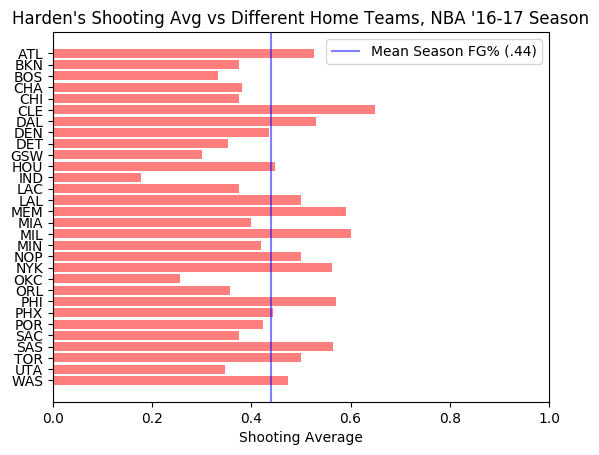

In [197]:
# vector of all the home teams, including his own home team
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np

season_avg = harden_shotdata['SHOT_MADE_FLAG'].mean() # 0.44

# all team abbreviations, alphabetized
home_teams = sorted(harden_shotdata['HTM'].unique())
shot_avg = harden_shotdata.groupby('HTM')['SHOT_MADE_FLAG'].mean()

# creating the bar plot
fig, ax = plt.subplots()
y_pos = np.arange(len(home_teams))
plt.barh(y_pos, shot_avg, align='center', alpha=0.5, color = 'red')
plt.yticks(y_pos, home_teams)
ax.invert_yaxis()
plt.xlim(0,1)
plt.xlabel("Shooting Average")
plt.title("Harden's Shooting Avg vs Different Home Teams, NBA '16-17 Season")
# drawing a vertical line of his 2016-2017 shooting average
plt.axvline(x=season_avg, color ='blue', alpha=0.5, 
            label= "Mean Season FG% (.44)")
plt.legend(loc='upper right')
plt.show()

### Observations

When we look at Harden's shooting average over the whole of the season relative to who was playing at home, a couple of interesting observations emerge. 

Firstly, Harden performed well under his season average against the Indiana Pacers (IND) and the Oklahoma City Thunder (OKC). Secondly, he performed pretty much close to his own average when playing at home in Houston (HOU). He had a remarkable strong performance away at Cleveland.

On the subject of Harden's background, Harden played for Arizona State near Phoenix when he was in college, and his numbers at Phoenix mirror those of his numbers when playing at home in Houston. He also played for Oklahoma City for three years before transferring to the Rockets, and his second least successful performance away from home was in Oklahoma. 

### Plot of Harden's field goal percentage vs distance from basket

The mark of a good shooter in basketball is being able to land shots from all around the court. We can make a line plot depicting Harden's field goal percentage, while also taking into account what percentage of his shots actually occur at that distance. 

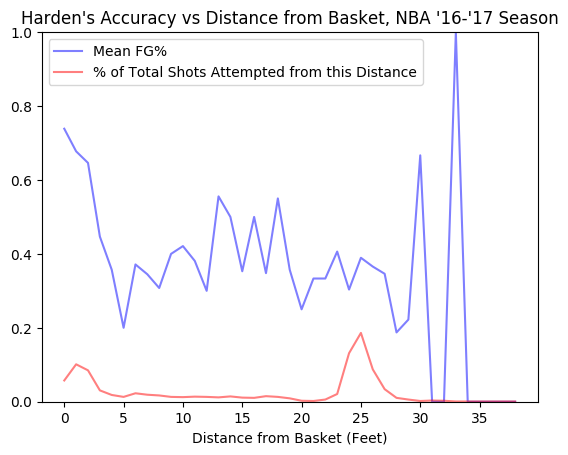

In [203]:
from matplotlib import axes
# grouping by shot_distance, and returning the avg shots landed and count of shots attempted
avg_by_distance = harden_shotdata.groupby('SHOT_DISTANCE')['SHOT_MADE_FLAG'].agg(['mean','count'])
total_games = len(harden_shotdata)
distances = np.arange(len(avg_by_distance))
pct_of_attempts = avg_by_distance['count'] / total_games
plt.plot(distances, avg_by_distance['mean'], 
            color = 'blue', alpha=0.5, 
            label='Mean FG%')
plt.plot(distances, pct_of_attempts, 
            color = 'red', alpha=0.5, 
        label='% of Total Shots Attempted from this Distance')
plt.legend(loc='best')
plt.title("Harden's Accuracy vs Distance from Basket, NBA '16-'17 Season")
plt.xlabel("Distance from Basket (Feet)")
plt.ylim(0,1)
plt.show()

### Observations

As we can see, a significant portion of Harden's attempted shots occur at around 22 - 27 from the basket. In the NBA, the 3-point line is 23.75 feet from the hoop, and 22 feet from the hoop in the corners, so this is of course correlated with his 3-point attempts. About a fifth of his shots take place from behind the 3-point line, and around a tenth of them are directly up against the basket. 

We can see thusly that while Harden is more actively shooting behind the 3-point line, he achieves the most success when he gets as close to the basket as possible. The plot does show that he remains a formidable two-point shooter even when not directly against the basket, scoring at or above his season average (44%). 


Finally, we note that he has attempted a handful of grandiose shots from well behind the line and been successful, but these occasions happen very seldom.

A potential follow-up question would be to look at how distance correlates with the amount of points or percentage of total points scored, but I won't explore that here.